# Transfer Learning

This notebook shows how to apply transfer learning on image datasets

### Import all the needed modules

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, precision_recall_curve

sns.set()

### Define paths for the data location and the place to save the model

The data is contained in the `rice.zip` with the presentations

In [2]:
TRAIN_DIR = 'rice/train/'
TEST_DIR = 'rice/test/'
CKPT_DIR='checkpoints/vgg_16_ckpts_{epoch:03d}.ckpt'
BEST_DIR='checkpoints/vgg_16_best.ckpt'

### Load the images and add augmentations

The training/validation set has multiple random data transformations while the training set is just scaled for the sake of normalization

In [3]:
train_idg = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=360,
    zoom_range=0.5,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    rescale=1.0/255
)
test_idg = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

class_mode = 'binary'
classes = {
    'healthy': 0,
    'unhealthy': 1,
}

train_gen = train_idg.flow_from_directory(TRAIN_DIR, (128, 128),
                                          seed=0,
                                          batch_size=32,
                                          subset='training',
                                          class_mode=class_mode,
                                          classes=classes)

valid_gen = train_idg.flow_from_directory(TRAIN_DIR, (128, 128),
                                          seed=0,
                                          batch_size=32,
                                          subset='validation',
                                          class_mode=class_mode,    
                                          classes=classes)

test_gen = test_idg.flow_from_directory(TEST_DIR, (128, 128),
                                        class_mode=class_mode,
                                        classes=classes,
                                        shuffle=False,
                                        batch_size=1)

Found 139 images belonging to 2 classes.
Found 34 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [4]:
def view_generator_data(gen, n):
    data = [next(gen) for _ in range(n)]
    data = list(zip(*data))
    X, y = data
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y

def view_images(X, y, n=None):
    n = n or len(X)
    for i in range(n):
        plt.imshow(X[i])
        plt.grid(None)
        plt.show()
        print('Label: ', y[i])

In [5]:
train_X, train_y = view_generator_data(train_gen, 1)
train_gen.reset()

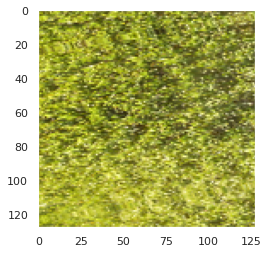

Label:  0.0


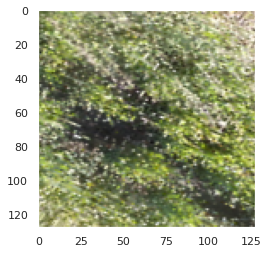

Label:  1.0


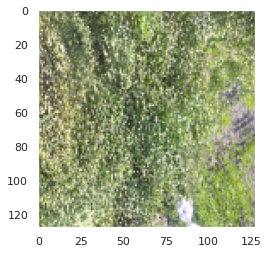

Label:  1.0


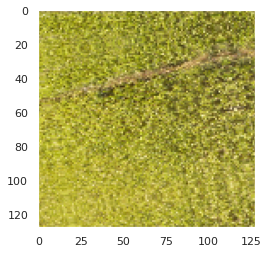

Label:  1.0


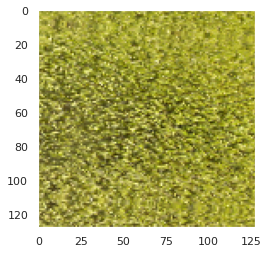

Label:  0.0


In [6]:
view_images(train_X, train_y)

### Create a base model and add additional layers

Load the keras VGG model without the last/top layers and add the needed layers to solve the classification problem. Also some of the initial layers of the VGG model are set to be not trainable since only fine tuning is done to the model

In [7]:
img_input = tf.keras.layers.Input((128, 128, 3))
base_model = tf.keras.applications.VGG16(include_top=False,
                   weights='imagenet',
                   input_tensor=img_input)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=img_input, outputs=predictions)

for layer in base_model.layers[:-4]:
    layer.trainable = False
    
model.compile('adam', 'binary_crossentropy')

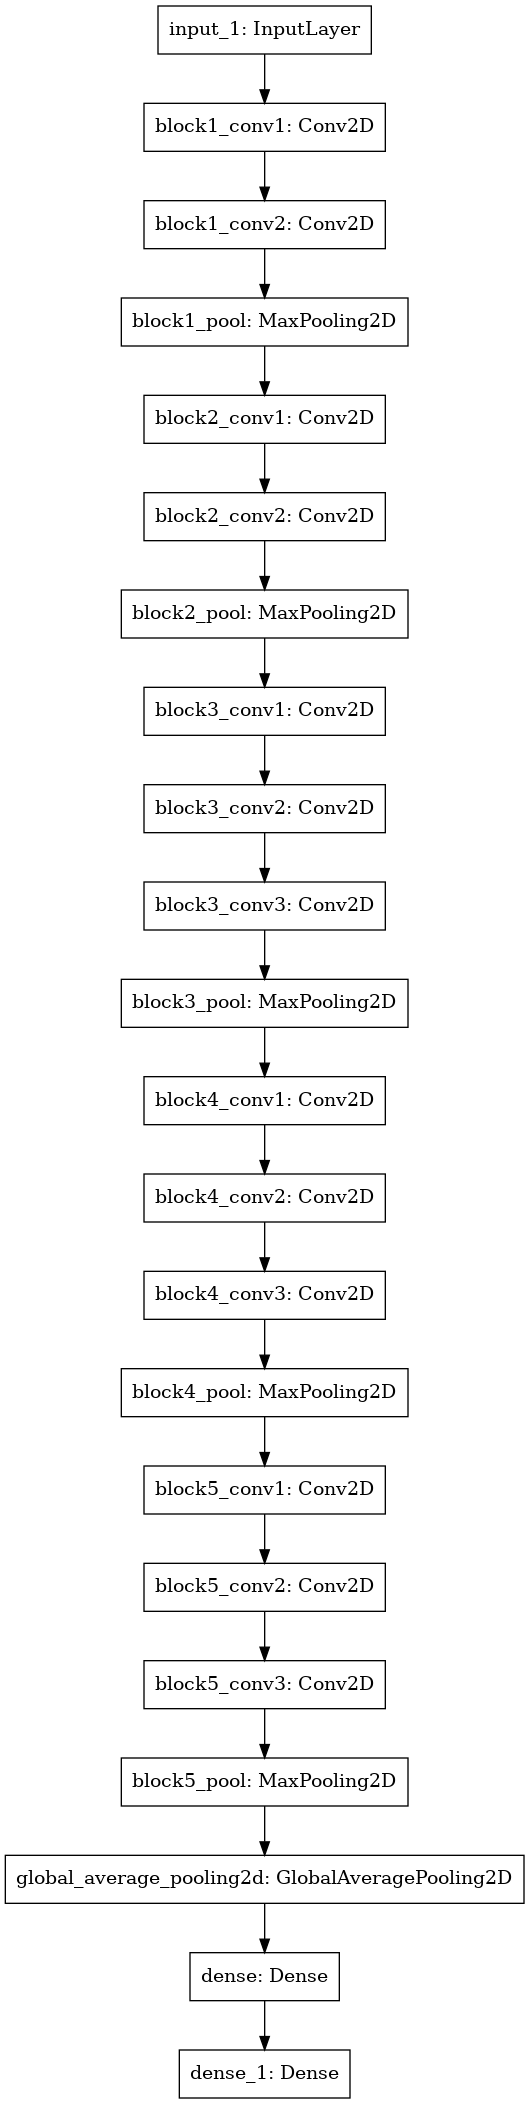

In [8]:
tf.keras.utils.plot_model(model)

### Train the Keras model

Different callbacks are also added save the model and regularize training

In [9]:
es = tf.keras.callbacks.EarlyStopping(patience=20)
os.makedirs(os.path.dirname(CKPT_DIR), exist_ok=True)
os.makedirs(os.path.dirname(BEST_DIR), exist_ok=True)
mc = tf.keras.callbacks.ModelCheckpoint(CKPT_DIR)
bm = tf.keras.callbacks.ModelCheckpoint(BEST_DIR, save_best_only=True)
hst = model.fit(
    train_gen,
    steps_per_epoch=5,
    epochs=20,
    callbacks=[es, mc, bm],
    validation_data=valid_gen,
    validation_steps=1,
    max_queue_size=1
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 1 steps
Epoch 1/20
4/5 [=======================>......] - ETA: 8s - loss: 1.7057 WARNING:tensorflow:From /home/snowtsuku/.miniconda/envs/machine-learning/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: checkpoints/vgg_16_ckpts_001.ckpt/assets
INFO:tensorflow:Assets written to: checkpoints/vgg_16_best.ckpt/assets
5/5 [==============================] - 58s 12s/step - loss: 1.5230 - val_loss: 0.6915
Epoch 2/20
5/5 [==============================] - 51s 10s/step - loss: 0.7408 - val_loss: 0.7474
Epoch 3/20
4/5 [=======================>......] - ETA: 8s - loss: 0.7101 INFO:tensorflow:Assets written to:

In [10]:
!ls checkpoints/

vgg_16_best.ckpt       vgg_16_ckpts_007.ckpt  vgg_16_ckpts_014.ckpt
vgg_16_ckpts_001.ckpt  vgg_16_ckpts_008.ckpt  vgg_16_ckpts_015.ckpt
vgg_16_ckpts_002.ckpt  vgg_16_ckpts_009.ckpt  vgg_16_ckpts_016.ckpt
vgg_16_ckpts_003.ckpt  vgg_16_ckpts_010.ckpt  vgg_16_ckpts_017.ckpt
vgg_16_ckpts_004.ckpt  vgg_16_ckpts_011.ckpt  vgg_16_ckpts_018.ckpt
vgg_16_ckpts_005.ckpt  vgg_16_ckpts_012.ckpt  vgg_16_ckpts_019.ckpt
vgg_16_ckpts_006.ckpt  vgg_16_ckpts_013.ckpt  vgg_16_ckpts_020.ckpt


### Load the training data from the python generators

Since the keras utilities create generators, they should be called to create the data

In [11]:
test_X, test_y = view_generator_data(test_gen, test_gen.n)

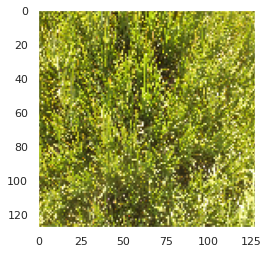

Label:  0.0


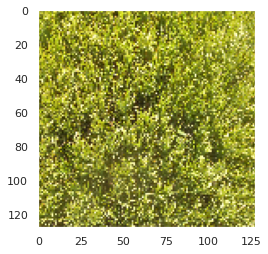

Label:  0.0


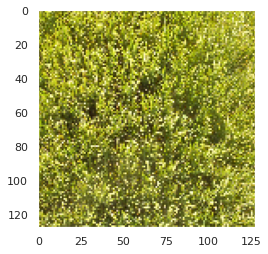

Label:  0.0


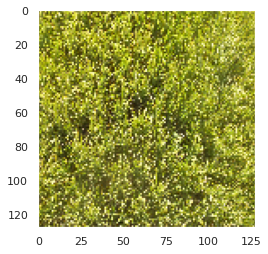

Label:  0.0


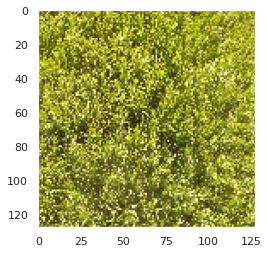

Label:  0.0


In [12]:
view_images(test_X, test_y)

### Predict the result using the best model

In [13]:
best_model = tf.keras.models.load_model(BEST_DIR)
test_y_pred = best_model.predict(test_X)

In [14]:
roc_auc_score(test_y, test_y_pred)

0.9377777777777778

In [15]:
pr, r, thr = precision_recall_curve(test_y, test_y_pred)

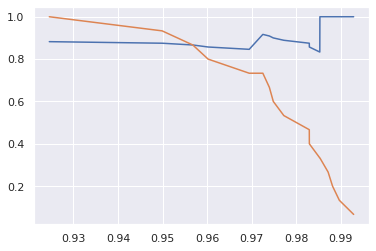

In [16]:
plt.plot(thr, pr[:-1])
plt.plot(thr, r[:-1])
plt.show()

In [17]:
threshold = 0.955

In [18]:
accuracy_score(test_y > threshold, test_y_pred > threshold)

0.8666666666666667

In [19]:
print(classification_report(test_y > threshold, test_y_pred > threshold))

              precision    recall  f1-score   support

       False       0.87      0.87      0.87        15
        True       0.87      0.87      0.87        15

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30



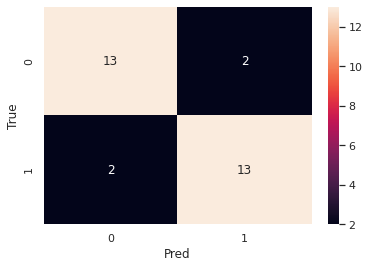

In [20]:
sns.heatmap(confusion_matrix(test_y > threshold, test_y_pred > threshold), annot=True)
plt.ylabel('True')
plt.xlabel('Pred')
plt.show()